# Pair Research (research)

First we start with importing required libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now we can import the file we want to explore. In this case the filename is "user_skill_graph.json"

In [2]:
df = pd.read_json(path_or_buf="output/user_skill_graph-TEST.json", orient="records");

Now we can do a basic analysis of ranking data. Let's find the mean and standard deviation of the dataset as well as plot the values.

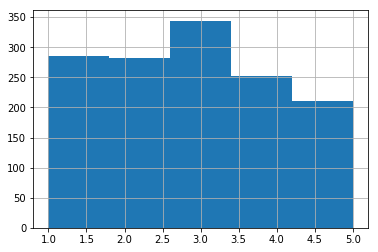

count    1374.000000
mean        2.870451
std         1.348015
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: value, dtype: float64


In [3]:
df.value.hist(bins=5)
plt.show()
print df.value.describe()

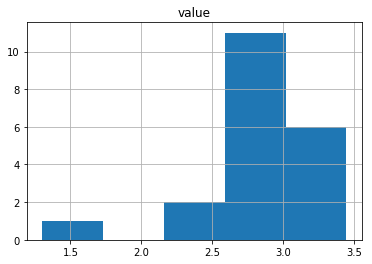

In [4]:
df.groupby('helperId').mean().hist(bins=5)
plt.show()

Now let's move on to the big questions we wanted to ask about the dataset

## Question 1: Have skill ratings improved over time?

Let's take all the users, and plot out their skill rankings for each pairing session.

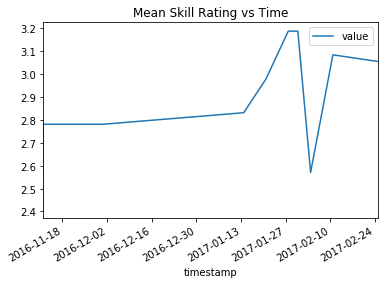

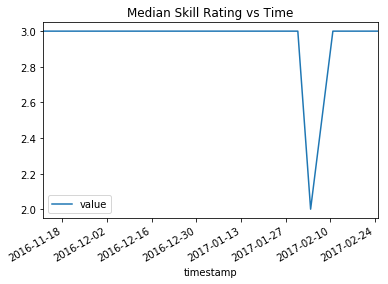

In [5]:
df.groupby("timestamp").mean().plot(title="Mean Skill Rating vs Time")
df.groupby("timestamp").median().plot(title="Median Skill Rating vs Time")
plt.show()

This isn't very helpful so let's breakdown each skill to see how things spread across topics. Let's split our table by category to turn a dictionary of the form: 
``` Javascript
{
    categories: ["ios", "data", "urg"], 
    value: 5
}
```
to three rows of the form:
``` Javascript
{[categories: ["ios"], value: 5], 
 [categories: ["data"], value: 5],
 [categories: ["urg"], value: 5],}
```

In [6]:
df['categories'] = df['categories'].apply(tuple)

In [7]:
new_rows = []
for index, row in df.iterrows():
    new_rows.extend([[row['helperId'], row['timestamp'], row['task'][0], nn, row['value']] for nn in row.categories])
expanded_df = pd.DataFrame(new_rows,columns=['helperId', 'timestamp', 'task', 'category', 'value'])

In [8]:
expanded_df.groupby(['category', 'helperId'])

## Question 2: How Does Skill Demand compare to the amount of people who can help? 

To calculate this, we can take the number of tasks that have requested this topic (scoped to a specific pairingId), and plot it against the number people who have rated that skill a 4 or 5

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


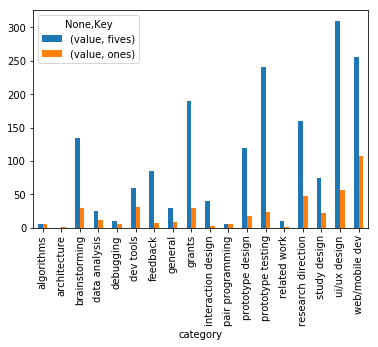

In [9]:
supply_df = expanded_df[["timestamp", "category", "value"]]
supply_df.set_index('category')
supply_df.loc[:,('Key')] = 'fives'
sdf = supply_df[supply_df.value >= 5]
# supply_df[supply_df.value >= 4].groupby("category").size().plot(kind='bar', color='red')

demand_df = expanded_df[["timestamp", "category", "value"]]
demand_df.set_index('category')
demand_df.loc[:,('Key')] = 'ones'
ddf = demand_df[demand_df.value <= 1]
# demand_df[demand_df.value <= 2].groupby("category").size().plot(kind='bar', color='blue')

DF = pd.concat([sdf,ddf],keys=['fives','ones'])

DFGroup = DF.groupby(['category', 'Key'])
DFGPlot = DFGroup.sum().unstack('Key').plot(kind='bar')
plt.show()

## Question 3: On average, how many skill categories are requested per help request?

This just translates to the average number of items in the "categories" array in our original dataframe

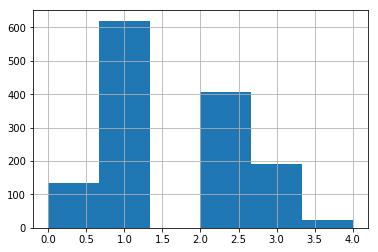

count    1374.000000
mean        1.524745
std         0.905055
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: categories, dtype: float64

In [10]:
df.categories.map(len).hist(bins=6)
plt.show()
df.categories.map(len).describe()

Help request that are outliers in this situation are:

In [11]:
df.categories.sort_values(ascending=False).iloc[0]

(u'web/mobile dev', u'ui/ux design')

In [12]:
expanded_df.category.value_counts()

web/mobile dev        406
ui/ux design          320
research direction    270
grants                188
prototype testing     181
brainstorming         179
dev tools              96
study design           92
prototype design       90
feedback               80
interaction design     45
data analysis          44
general                40
algorithms             16
debugging              16
pair programming       14
related work           12
architecture            6
Name: category, dtype: int64

## Question 4: What does the Group skillset look like over time?

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736349.855023, right=736349.855023
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736363.860467, right=736363.860467
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736370.844354, right=736370.844354
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736384.87306, r

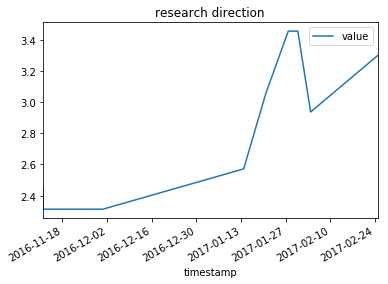

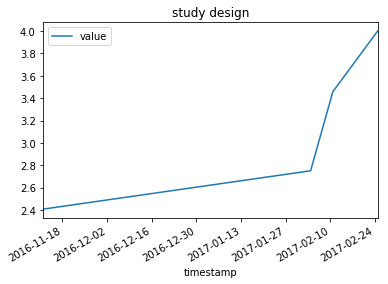

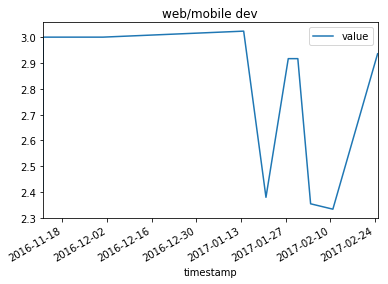

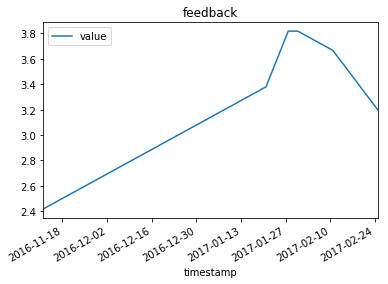

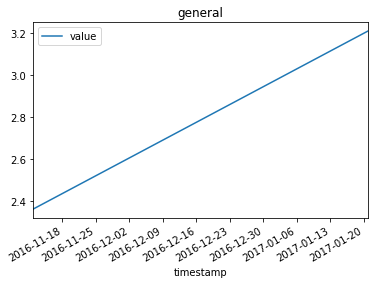

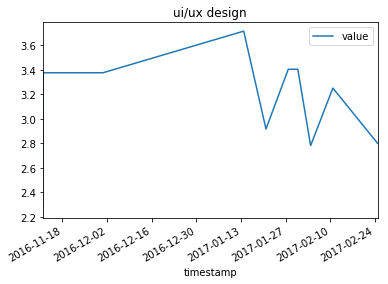

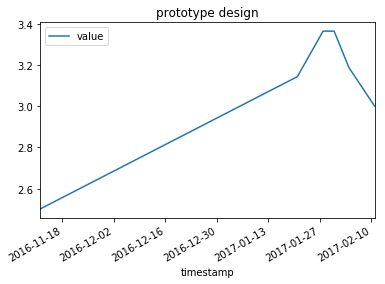

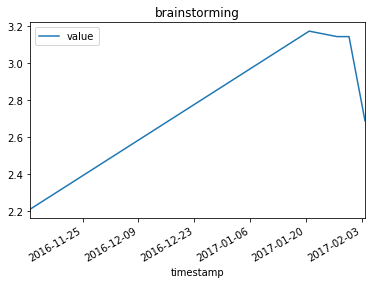

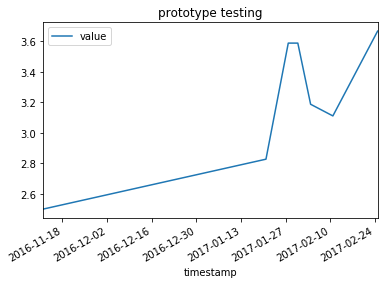

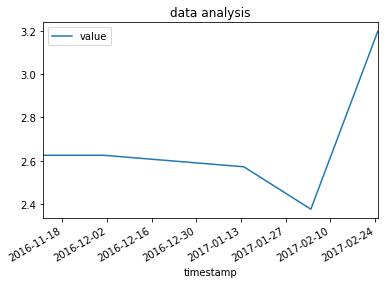

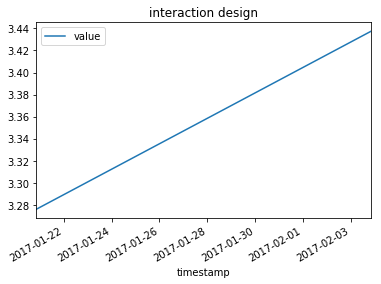

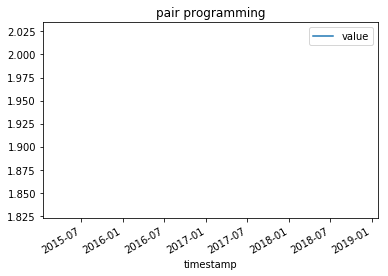

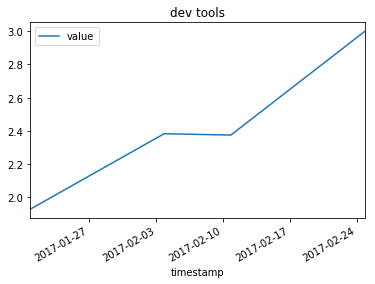

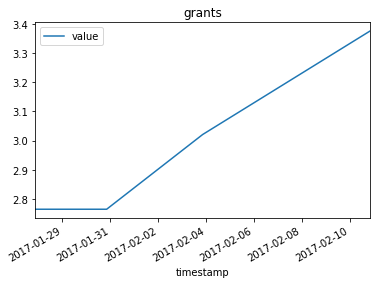

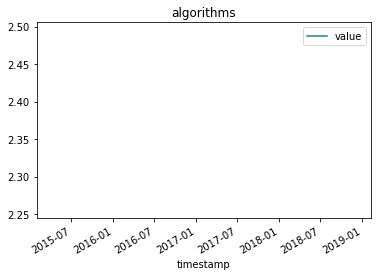

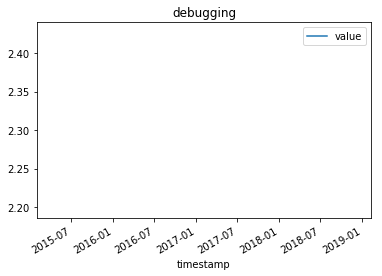

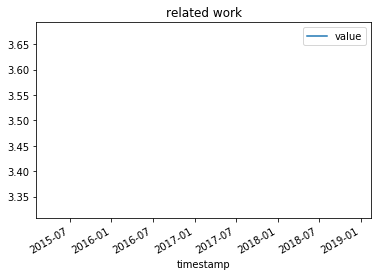

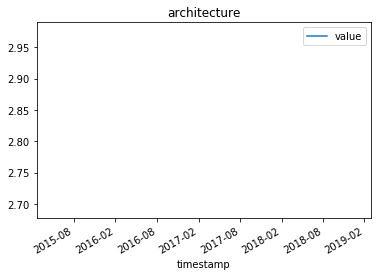

In [13]:
categories = list(expanded_df.category.unique())
group_skillset = expanded_df[["timestamp", "category", "value"]]
for category in categories:
    values_to_plot = group_skillset[group_skillset.category == category]
    values_to_plot.groupby("timestamp").mean().plot(title=category)
plt.show()

## What kind of skill requests get abnormal scores? 

Call this to clean the data a bit before performing any calculations

In [14]:
df['task'] = df['task'].apply(lambda x: x[0])

---
Tasks most frequently rated "1"

In [15]:
df[df.value == 1][['task']].ix[:,0].value_counts().head(10)

delta lab check-in/monitoring system                                                                 9
something pleasant to look at (maybe WebGL???)                                                       9
slackbot to create emojis from people's published photos (fb, instagram, etc)                        9
simple websocket-based app to allow students to anonymously request clarification during lectures    9
finish our sprint plan                                                                               8
SprintTeam: Learning how to sprint plan, SpaceTeam style                                             8
Fixing flow between ViewControllers on iOS Main.storyboard                                           8
having problems getting meteor app to install on iphone (possibly signing certificate problem)       8
feature detection in tracking.js (computer vision :P )                                               7
integrating dart script with meteor app                                  

---
Tasks most frequently rated "1" or "2"

In [16]:
df[df.value <= 2][['task']].ix[:,0].value_counts().head(10)

simple websocket-based app to allow students to anonymously request clarification during lectures                                                  18
Brainstorming ways to find the underlying concepts responsible for DOM changes                                                                     18
something pleasant to look at (maybe WebGL???)                                                                                                     15
feature detection in tracking.js (computer vision :P )                                                                                             14
help me start writing my URG                                                                                                                       14
fix app signing issues and get app to download onto an iPhone via diwai                                                                            13
having problems getting meteor app to install on iphone (possibly signing certificate problem)      

Tasks most frequently rated "5"

In [17]:
df[df.value == 5][['task']].ix[:,0].value_counts().head(10)

Usability testing for UI                                                                                                       12
want to make something happy to help me cope with election results (leaving at 5pm)                                             9
Organize DTR Cubby                                                                                                              8
QA with current paper prototype and brainstorm ways to improve (sketching out interface ideas)                                  8
I want to build something happy with Katie                                                                                      6
?????? anything lol something happy                                                                                             6
Work on interface (sketches etc) for actional feedback system for the research canvas                                           6
Do a user test with ~pipe cleaners~ with our latest paper prototype. self-identified begin

---
Tasks most frequently rated "5" or "4"

In [18]:
df[df.value >= 4][['task']].ix[:,0].value_counts().head(10)

Work on interface (sketches etc) for actional feedback system for the research canvas             16
I want to build something happy with Katie                                                        15
want to make something happy to help me cope with election results (leaving at 5pm)               15
Usability testing for UI                                                                          14
Narrow down brainstormed ideas to three                                                           14
Organize DTR Cubby                                                                                12
?????? anything lol something happy                                                               11
Design 'Snapshot' (for review by Mentors and Peers) of Research Progress throughout a sprint      10
QA with current paper prototype and brainstorm ways to improve (sketching out interface ideas)    10
delta lab check-in/monitoring system                                                       

It looks like people are most comfortable with easier tasks and testing, and less likely to want to help with more technical tasks and bugs. 

## Individual score rankings 

Let's explore the distribution of individual skill rankings. 

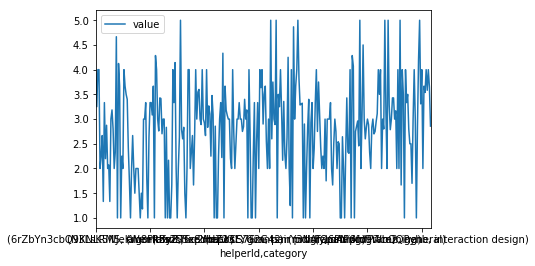

In [19]:
expanded_df.groupby(['helperId', 'category']).mean().plot()
plt.show()

In [20]:
def test():
    return 6

In [11]:
print test()

6
